In [112]:
# Get data

from kaggle.api.kaggle_api_extended import KaggleApi
import zipfile
import os

api = KaggleApi()
api.authenticate()

for file in ['train.tsv', 'test.tsv']:
    api.competition_download_file('sentiment-analysis-on-movie-reviews', f'{file}.zip', path='./')

    with zipfile.ZipFile(f'{file}.zip', 'r') as zip_ref:
        zip_ref.extractall('./')

    os.remove(f'{file}.zip')

  0%|          | 0.00/1.28M [00:00<?, ?B/s]

100%|██████████| 1.28M/1.28M [00:00<00:00, 6.01MB/s]


100%|██████████| 494k/494k [00:00<00:00, 2.72MB/s]

100%|██████████| 494k/494k [00:00<00:00, 2.72MB/s]

In [210]:
# load data
import pandas as pd
df = pd.read_csv('train.tsv', sep = '\t')

### Check distribution of sentiments


<AxesSubplot:>

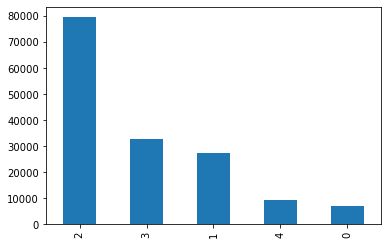

In [211]:
df['Sentiment'].value_counts().plot(kind='bar')

In [212]:
df.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


In [213]:
df = df.drop_duplicates(subset = ['SentenceId'], keep = 'first')

In [214]:
df.head()


,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
63,64,2,"This quiet , introspective and entertaining in...",4
81,82,3,"Even fans of Ismail Merchant 's work , I suspe...",1
116,117,4,A positively thrilling combination of ethnogra...,3
156,157,5,Aggressive self-glorification and a manipulati...,1


# Create input

In [215]:
import numpy as np

seq_len = 512
num_samples = len(df)

num_samples, seq_len

(8529, 512)

In [216]:
df.shape

(8529, 4)

In [217]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
tokens = tokenizer(df['Phrase'].tolist(),max_length= seq_len, truncation= True, padding = 'max_length', add_special_tokens = True, return_tensors = 'np')

In [218]:
# save numpy arrays

with open('movie-xids.npy', 'wb') as f:
    np.save(f, tokens['input_ids'])
with open('movie-xmask.npy', 'wb') as f:
    np.save(f, tokens['attention_mask'])

In [219]:
# y variable

arr = df['Sentiment'].values

In [220]:
 # onehot encoding
    
labels = np.zeros((num_samples, arr.max()+ 1))

# index arr to 1

labels[np.arange(num_samples), arr] = 1

In [221]:
with open('movie-labels.npy', 'wb') as f:
    np.save(f, labels)

# Dataset

In [222]:
Xids = tokens['input_ids']
Xmask = tokens['attention_mask']

In [223]:
import tensorflow as tf

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

dataset = tf.data.Dataset.from_tensor_slices((Xids,Xmask,labels))

Num GPUs Available:  1


In [224]:
len(dataset)

8529

In [225]:
# convert it to kwargs

def map_func(input_ids,masks, labels):
    return {'input_ids': input_ids, 'attention_masks': masks}, labels

In [226]:
dataset = dataset.map(map_func)

In [227]:
len(dataset)

8529

# Shuffle and Batch

In [228]:
batch_size = 8

dataset = dataset.shuffle(100).batch(batch_size, drop_remainder = True)

In [229]:
len(dataset)

1066

In [231]:
# train and test skip skips the first 8000, val takes the rest

train_ds = dataset.take(900)
val_ds = dataset.skip(900)

In [232]:
len(dataset)

1066

In [233]:
# save

tf.data.experimental.save(train_ds,'train')
tf.data.experimental.save(val_ds,'val')

# Initialize Bert Model

In [234]:
from transformers import TFAutoModel


In [235]:
bert = TFAutoModel.from_pretrained('bert-base-cased')

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [236]:
bert.summary()

Model: "tf_bert_model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  108310272 
                                                                 
Total params: 108,310,272
Trainable params: 108,310,272
Non-trainable params: 0
_________________________________________________________________


# Transfer Learning

In [237]:
import tensorflow as tf

#define inputs
input_ids = tf.keras.layers.Input(shape = (512,), name = 'input_ids', dtype = 'int32')
mask =tf.keras.layers.Input(shape = (512,), name = 'attention_masks', dtype = 'int32')

In [238]:
#transformer

# bert.bert returns two activations -> 0 = raw 1 = max pooled
embeddings = bert.bert(input_ids, attention_mask =mask)[1]



In [239]:
#classifier head

x = tf.keras.layers.Dense(1024,activation = 'relu')(embeddings)
y = tf.keras.layers.Dense(5, activation = 'softmax', name = 'outputs')(x)

In [240]:
model = tf.keras.Model(inputs = [input_ids, mask],outputs = y)

In [241]:
# freeze bert layer

model.layers[2].trainable = False

In [242]:
optimizer =  tf.keras.optimizers.Adam(lr = 5e-5, decay = 1e-6)
loss = tf.keras.losses.CategoricalCrossentropy()
acc = tf.keras.metrics.CategoricalAccuracy('accuracy')

model.compile(optimizer = optimizer, loss = loss, metrics = [acc])

C:\Users\91760\AppData\Roaming\Python\Python38\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


# Train Model

In [243]:
history = model.fit(train_ds, 
                    validation_data = val_ds,
                    epochs = 5)

Epoch 1/5


ResourceExhaustedError: Graph execution error:

Detected at node 'model_7/bert/encoder/layer_._2/attention/self/dropout_229/dropout/random_uniform/RandomUniform' defined at (most recent call last):
    File "C:\Users\91760\anaconda3\envs\ml\lib\runpy.py", line 194, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "C:\Users\91760\anaconda3\envs\ml\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "C:\Users\91760\anaconda3\envs\ml\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
      app.launch_new_instance()
    File "C:\Users\91760\anaconda3\envs\ml\lib\site-packages\traitlets\config\application.py", line 845, in launch_instance
      app.start()
    File "C:\Users\91760\anaconda3\envs\ml\lib\site-packages\ipykernel\kernelapp.py", line 612, in start
      self.io_loop.start()
    File "C:\Users\91760\anaconda3\envs\ml\lib\site-packages\tornado\platform\asyncio.py", line 149, in start
      self.asyncio_loop.run_forever()
    File "C:\Users\91760\anaconda3\envs\ml\lib\asyncio\base_events.py", line 570, in run_forever
      self._run_once()
    File "C:\Users\91760\anaconda3\envs\ml\lib\asyncio\base_events.py", line 1859, in _run_once
      handle._run()
    File "C:\Users\91760\anaconda3\envs\ml\lib\asyncio\events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\91760\anaconda3\envs\ml\lib\site-packages\tornado\ioloop.py", line 690, in <lambda>
      lambda f: self._run_callback(functools.partial(callback, future))
    File "C:\Users\91760\anaconda3\envs\ml\lib\site-packages\tornado\ioloop.py", line 743, in _run_callback
      ret = callback()
    File "C:\Users\91760\anaconda3\envs\ml\lib\site-packages\tornado\gen.py", line 787, in inner
      self.run()
    File "C:\Users\91760\anaconda3\envs\ml\lib\site-packages\tornado\gen.py", line 748, in run
      yielded = self.gen.send(value)
    File "C:\Users\91760\anaconda3\envs\ml\lib\site-packages\ipykernel\kernelbase.py", line 381, in dispatch_queue
      yield self.process_one()
    File "C:\Users\91760\anaconda3\envs\ml\lib\site-packages\tornado\gen.py", line 225, in wrapper
      runner = Runner(result, future, yielded)
    File "C:\Users\91760\anaconda3\envs\ml\lib\site-packages\tornado\gen.py", line 714, in __init__
      self.run()
    File "C:\Users\91760\anaconda3\envs\ml\lib\site-packages\tornado\gen.py", line 748, in run
      yielded = self.gen.send(value)
    File "C:\Users\91760\anaconda3\envs\ml\lib\site-packages\ipykernel\kernelbase.py", line 365, in process_one
      yield gen.maybe_future(dispatch(*args))
    File "C:\Users\91760\anaconda3\envs\ml\lib\site-packages\tornado\gen.py", line 209, in wrapper
      yielded = next(result)
    File "C:\Users\91760\anaconda3\envs\ml\lib\site-packages\ipykernel\kernelbase.py", line 268, in dispatch_shell
      yield gen.maybe_future(handler(stream, idents, msg))
    File "C:\Users\91760\anaconda3\envs\ml\lib\site-packages\tornado\gen.py", line 209, in wrapper
      yielded = next(result)
    File "C:\Users\91760\anaconda3\envs\ml\lib\site-packages\ipykernel\kernelbase.py", line 543, in execute_request
      self.do_execute(
    File "C:\Users\91760\anaconda3\envs\ml\lib\site-packages\tornado\gen.py", line 209, in wrapper
      yielded = next(result)
    File "C:\Users\91760\anaconda3\envs\ml\lib\site-packages\ipykernel\ipkernel.py", line 306, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "C:\Users\91760\anaconda3\envs\ml\lib\site-packages\ipykernel\zmqshell.py", line 536, in run_cell
      return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
    File "C:\Users\91760\anaconda3\envs\ml\lib\site-packages\IPython\core\interactiveshell.py", line 2877, in run_cell
      result = self._run_cell(
    File "C:\Users\91760\anaconda3\envs\ml\lib\site-packages\IPython\core\interactiveshell.py", line 2923, in _run_cell
      return runner(coro)
    File "C:\Users\91760\anaconda3\envs\ml\lib\site-packages\IPython\core\async_helpers.py", line 68, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\91760\anaconda3\envs\ml\lib\site-packages\IPython\core\interactiveshell.py", line 3146, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\91760\anaconda3\envs\ml\lib\site-packages\IPython\core\interactiveshell.py", line 3338, in run_ast_nodes
      if (await self.run_code(code, result,  async_=asy)):
    File "C:\Users\91760\anaconda3\envs\ml\lib\site-packages\IPython\core\interactiveshell.py", line 3418, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "<ipython-input-243-bfe82f7e859e>", line 1, in <module>
      history = model.fit(train_ds,
    File "C:\Users\91760\AppData\Roaming\Python\Python38\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\91760\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py", line 1384, in fit
      tmp_logs = self.train_function(iterator)
    File "C:\Users\91760\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py", line 1021, in train_function
      return step_function(self, iterator)
    File "C:\Users\91760\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py", line 1010, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\91760\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py", line 1000, in run_step
      outputs = model.train_step(data)
    File "C:\Users\91760\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py", line 859, in train_step
      y_pred = self(x, training=True)
    File "C:\Users\91760\AppData\Roaming\Python\Python38\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\91760\AppData\Roaming\Python\Python38\site-packages\keras\engine\base_layer.py", line 1096, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\91760\AppData\Roaming\Python\Python38\site-packages\keras\utils\traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\91760\AppData\Roaming\Python\Python38\site-packages\keras\engine\functional.py", line 451, in call
      return self._run_internal_graph(
    File "C:\Users\91760\AppData\Roaming\Python\Python38\site-packages\keras\engine\functional.py", line 589, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "C:\Users\91760\AppData\Roaming\Python\Python38\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\91760\AppData\Roaming\Python\Python38\site-packages\keras\engine\base_layer.py", line 1096, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\91760\AppData\Roaming\Python\Python38\site-packages\keras\utils\traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\91760\anaconda3\envs\ml\lib\site-packages\transformers\models\bert\modeling_tf_bert.py", line 655, in call
      encoder_outputs = self.encoder(
    File "C:\Users\91760\AppData\Roaming\Python\Python38\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\91760\AppData\Roaming\Python\Python38\site-packages\keras\engine\base_layer.py", line 1096, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\91760\AppData\Roaming\Python\Python38\site-packages\keras\utils\traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\91760\anaconda3\envs\ml\lib\site-packages\transformers\models\bert\modeling_tf_bert.py", line 429, in call
      for i, layer_module in enumerate(self.layer):
    File "C:\Users\91760\anaconda3\envs\ml\lib\site-packages\transformers\models\bert\modeling_tf_bert.py", line 433, in call
      layer_outputs = layer_module(
    File "C:\Users\91760\AppData\Roaming\Python\Python38\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\91760\AppData\Roaming\Python\Python38\site-packages\keras\engine\base_layer.py", line 1096, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\91760\AppData\Roaming\Python\Python38\site-packages\keras\utils\traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\91760\anaconda3\envs\ml\lib\site-packages\transformers\models\bert\modeling_tf_bert.py", line 399, in call
      attention_outputs = self.attention(
    File "C:\Users\91760\AppData\Roaming\Python\Python38\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\91760\AppData\Roaming\Python\Python38\site-packages\keras\engine\base_layer.py", line 1096, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\91760\AppData\Roaming\Python\Python38\site-packages\keras\utils\traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\91760\anaconda3\envs\ml\lib\site-packages\transformers\models\bert\modeling_tf_bert.py", line 343, in call
      self_outputs = self.self_attention(
    File "C:\Users\91760\AppData\Roaming\Python\Python38\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\91760\AppData\Roaming\Python\Python38\site-packages\keras\engine\base_layer.py", line 1096, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\91760\AppData\Roaming\Python\Python38\site-packages\keras\utils\traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\91760\anaconda3\envs\ml\lib\site-packages\transformers\models\bert\modeling_tf_bert.py", line 298, in call
      attention_probs = self.dropout(attention_probs, training=training)
    File "C:\Users\91760\AppData\Roaming\Python\Python38\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\91760\AppData\Roaming\Python\Python38\site-packages\keras\engine\base_layer.py", line 1096, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\91760\AppData\Roaming\Python\Python38\site-packages\keras\utils\traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\91760\AppData\Roaming\Python\Python38\site-packages\keras\layers\core\dropout.py", line 111, in call
      output = control_flow_util.smart_cond(training, dropped_inputs,
    File "C:\Users\91760\AppData\Roaming\Python\Python38\site-packages\keras\utils\control_flow_util.py", line 105, in smart_cond
      return tf.__internal__.smart_cond.smart_cond(
    File "C:\Users\91760\AppData\Roaming\Python\Python38\site-packages\keras\layers\core\dropout.py", line 108, in dropped_inputs
      return self._random_generator.dropout(
    File "C:\Users\91760\AppData\Roaming\Python\Python38\site-packages\keras\backend.py", line 1940, in dropout
      return tf.nn.dropout(inputs, rate=rate, noise_shape=noise_shape,
Node: 'model_7/bert/encoder/layer_._2/attention/self/dropout_229/dropout/random_uniform/RandomUniform'
OOM when allocating tensor with shape[8,12,512,512] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node model_7/bert/encoder/layer_._2/attention/self/dropout_229/dropout/random_uniform/RandomUniform}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_176146]